In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
tf.__version__

'1.15.0'

In [3]:

datadir = '../Data/phago/'

In [4]:
import glob

def read_mm(mfile):
    hm=np.memmap(mfile, dtype=np.int32, shape=(4,))
    shape = tuple(hm)
    del hm

    mm = np.memmap(mfile, dtype=np.float32, shape=shape)
    mm.shape
    #del mm
    amm = mm[:,:,:,[2, 0, 4, 0, 1]]
    amm = amm[:,:,:, [0,2,4]]
    del mm
    return amm

def read_data(globpattern):
    ifiles = glob.glob(globpattern) #'Data/AAI/tiffs_FSS_24h*.mm')
    ammdict = dict()
    for i in ifiles:
        amm = read_mm(i)
        amm_m = amm.mean(axis=(1,2), keepdims=True)
        amm_std = amm.std(axis=(1,2), keepdims=True)
        amm = (amm - amm_m)/amm_std
        print(amm.shape)
        ammdict[i.split('/')[-1]] = amm
   
    return ammdict

ammdict = read_data('../Data/phago/*.mm')

(7959, 64, 64, 3)
(7882, 64, 64, 3)
(8383, 64, 64, 3)
(7874, 64, 64, 3)
(8407, 64, 64, 3)


In [5]:
ammdict.keys()

dict_keys(['phago_Snail_Phago_R3.mm', 'phago_Snail_Phago_R1.mm', 'phago_Snail_Phago_R5.mm', 'phago_Snail_Phago_R4.mm', 'phago_Snail_Phago_R2.mm'])

In [6]:
tf.reset_default_graph()
#dud = tf.get_variable('v1', shape=[2])
sess = tf.Session()


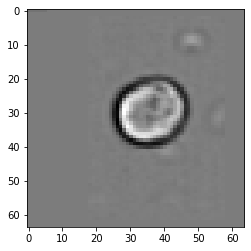

In [7]:
mmkeys = sorted(list(ammdict.keys()))
plt.imshow(ammdict[mmkeys[0]][4,:,:,0], cmap='gray')

In [8]:
cpdir = '../Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/'
checkpoint = 'best-checkpoint-21300'
if not cpdir.endswith('/'):
    cpdir += '/'

cpmeta = cpdir + checkpoint + '.meta'
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, cpdir + checkpoint)

W0916 16:38:52.554813 140394442676032 meta_graph.py:887] The saved meta_graph is possibly from an older release:
'metric_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


In [9]:
pq = 'dense_1/BiasAdd'.lower()
print(pq)
g = tf.get_default_graph()
ops = g.get_operations()
for op in ops:
    if pq in op.name.lower():
        print(op.name, op.outputs)

dense_1/biasadd
dense_1/BiasAdd [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/BiasAddGrad [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(128,) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/group_deps []
gradients/dense_1/BiasAdd_grad/tuple/control_dependency [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1 [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(128,) dtype=float32>]


In [10]:
a = sess.graph.get_tensor_by_name('dense_1/BiasAdd:0')
b = sess.graph.get_tensor_by_name('LeakyRelu_13:0') #'dense_1/BiasAdd:0')
sm = sess.graph.get_tensor_by_name('Softmax:0')

softmax = sess.graph.get_tensor_by_name('Softmax:0')
batch = sess.graph.get_tensor_by_name('Placeholder:0')

In [11]:
a, b, sm

(<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'LeakyRelu_13:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

In [12]:
#data.max(axis=(0,1,2)), data.min(axis=(0,1,2))

In [13]:
for k, v in ammdict.items():
    #print(k, v.shape)
    amm = ammdict[k]
    print(len(amm))
    mask = np.any(np.isnan(amm), axis=(1,2,3))
    amm = amm[~mask]
    print(len(amm))
    ammdict[k] = amm

7959
7959
7882
7882
8383
8383
7874
7874
8407
8407


In [14]:
clusters = pd.read_csv("../Data/Snail2020/AllData.csv")
clusters.head()

,ClusterID,EventID,File Name,Index in File,Event Name,Comment,:Area_Intensity_DHR,:Bright.Detail.Intensity.R3_AdaptiveErode_BF_Ch02,:Bright.Detail.Intensity.R3_AdaptiveErode_BF_Ch11,:Circularity_AdaptiveErode_BF,...,:Intensity_AdaptiveErode_BF_Ch07,:Intensity_AdaptiveErode_BF_Ch11,:Lobe.Count_Morphology_DNA_Ch11,:Max.Pixel_Intensity_Bac_Ch07,:Max.Pixel_Intensity_SSC_Ch06,:Std.Dev_AdaptiveErode_BF_Ch01,FDL-X,FDL-Y,MST-X,MST-Y
0,27426,599,Snail1_EDTA_22_Nuc_processed,599,NaN,NaN,0.0,0.421276,0.996727,2.845171,...,2.269315,-1.312300,1.019241,0.000000,0.000000,1.355595,-4015.461400,6501.4126,2.99067,3.649607
1,27426,1005,Snail1_EDTA_22_Nuc_processed,1005,NaN,NaN,0.0,0.713405,1.342746,2.066545,...,1.575389,-0.567669,1.019241,0.000000,0.000000,2.879183,-3268.807400,5862.5650,2.99067,3.649607
2,27426,1709,Snail1_EDTA_22_Nuc_processed,1709,NaN,NaN,0.0,1.753186,1.317332,0.724890,...,0.414718,1.588493,1.019241,1.062898,9.158837,4.650456,9.861165,-5145.9120,2.99067,3.649607
3,27426,2267,Snail1_EDTA_22_Nuc_processed,2267,NaN,NaN,0.0,1.361206,1.402883,1.066349,...,1.609419,1.140282,1.019241,1.191142,0.682324,4.177154,-3590.194000,1424.3973,2.99067,3.649607
4,27426,2750,Snail1_EDTA_22_Nuc_processed,2750,NaN,NaN,0.0,0.414675,2.169115,2.065630,...,0.449730,-2.939040,1.019241,0.000000,11.793864,4.773194,-0.557998,-5210.2144,2.99067,3.649607


In [15]:
clusters['File Name'].unique()

array(['Snail1_EDTA_22_Nuc_processed', 'Snail1_Ice_10_Nuc_processed',
       'Snail1_NoBact_3_Nuc_processed', 'Snail1_Phago_16_Nuc_processed',
       'Snail2_EDTA_23_Nuc_processed', 'Snail2_Ice_11_Nuc_processed',
       'Snail2_NoBact_4_Nuc_processed', 'Snail2_Phago_17_Nuc_processed',
       'Snail3_EDTA_24_Nuc_processed', 'Snail3_Ice_12_Nuc_processed',
       'Snail3_NoBact_5_Nuc_processed', 'Snail4_EDTA_25_Nuc_processed',
       'Snail4_Ice_13_Nuc_processed', 'Snail4_NoBact_6_Nuc_processed',
       'Snail4_Phago_19_Nuc_processed', 'Snail5_EDTA_26_Nuc_processed',
       'Snail5_Ice_14_Nuc_processed', 'Snail5_NoBact_7_Nuc_processed',
       'Snail5_Phago_20_Nuc_processed'], dtype=object)

In [16]:
cdf = clusters[['ClusterID', 'File Name', 'Index in File']].copy()

In [17]:
def strindex(x):
    return str(x)

cdf.loc[:,'strindex'] = cdf['Index in File'].map(strindex)
cdf[cdf["File Name"] == 'Snail1_Phago_16_Nuc_processed'].sort_values('strindex')['Index in File'].head(50)

5923     1002
3308     1029
8009     1037
1217     1039
1212      104
11991    1051
17987    1068
10956    1079
3309     1091
16941    1098
16019    1105
5924     1114
3948     1125
8005      113
4981     1131
11992    1138
15015    1160
15016    1161
3949     1162
11993    1169
10957    1170
1218     1173
15017    1185
13958     120
9022     1208
8010     1230
3021     1234
3310     1252
4982     1270
2121     1275
11994    1277
16020    1289
9023     1293
5925     1305
11995    1306
7096     1308
16942    1310
5926     1315
15000     132
2119      136
16943    1365
8011     1369
3950     1372
3951     1373
15018    1382
9963     1384
1219     1390
16944    1403
15019    1409
16021    1415
Name: Index in File, dtype: int64

In [41]:
#cdf.groupby('ClusterID').agg('count')

In [26]:
ammdict[list(ammdict.keys())[2]].shape

(8383, 64, 64, 3)

In [20]:
images = sess.graph.get_tensor_by_name('Placeholder:0')
adflist = list()
d2list = list()
for k, v in ammdict.items():
    d2, r2, p2 = sess.run([a, b, sm], feed_dict={images:v[:, 16:48, 16:48, :]})
    d2list.append(d2)
    p2x = np.argmax(p2, axis=-1)
    s = k.split('_')
    dataset = k #"{} {} {}".format(s[1], s[2], s[3][0])
    xdf = pd.DataFrame({'sm':p2x, 'smmax':p2.max(axis=-1), 'dataset':dataset})
    adflist.append(xdf)

adf = pd.concat(adflist, axis=0)
d2array = np.concatenate(d2list)
d2array.shape

(609, 128)

In [21]:
adf.head()


,sm,smmax,dataset
0,0,0.988925,phago_only_PhagoOnly_R3.mm
1,4,0.547325,phago_only_PhagoOnly_R3.mm
2,4,0.542458,phago_only_PhagoOnly_R3.mm
3,0,0.994146,phago_only_PhagoOnly_R3.mm
4,0,0.658032,phago_only_PhagoOnly_R3.mm


In [22]:
np.histogram(adf['sm'], bins=[0,.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

(array([292,   1,   1,  11, 192,  77,  35]),
 array([0. , 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]))

In [28]:
radf = adf.reset_index()

In [29]:
radf.to_pickle("phago_only_radf_pickle_2020.pkl")

In [69]:
rdir = "/n/core/cyto/_Data/Rohner/ROP/Imagestream Assay Data/Deep Learning_Feature_Analysis/Snail/Data for Classifier Analysis/phago only"
dirs = os.listdir(rdir)

glist = list()
for d in dirs:
    dd = rdir + '/' + d
    files = glob.glob(dd + '/*Ch1.*.tif')
    files = sorted(files, key=lambda x: int(os.path.basename(x).split("_")[2]))
    fdict = dict()
    #print(files[0:5])
    
    for index, f in enumerate(files):
        bf = os.path.basename(f)
        _sp = bf.split("_")
        cid = int(_sp[2])
        channel = int(_sp[3][2:].split(".")[0])
        glist.append({'index':index, 'cell_id':cid, 'directory':d, 'channel':channel})

gdf = pd.DataFrame(glist)

gdf.head()

    


,index,cell_id,directory,channel
0,0,158,PhagoOnly_R4,1
1,1,413,PhagoOnly_R4,1
2,2,503,PhagoOnly_R4,1
3,3,553,PhagoOnly_R4,1
4,4,606,PhagoOnly_R4,1


In [75]:
def mapdataset(x):
    #phago_only_PhagoOnly_R3.mm
    return "_".join(x.split("_")[2:])[:-3]

radf['directory'] = radf['dataset'].map(mapdataset)

In [78]:
merge_df = radf.merge(gdf, on=["index", "directory"])

In [81]:
merge_df[merge_df.directory == 'PhagoOnly_R2']

,index,sm,smmax,dataset,directory,cell_id,channel
72,0,0,0.402429,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,146,1
73,1,4,0.897734,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,320,1
74,2,0,0.377605,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,652,1
75,3,0,0.999063,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,724,1
76,4,0,0.904339,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,804,1
...,...,...,...,...,...,...,...
151,79,0,0.835413,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9237,1
152,80,0,0.999468,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9266,1
153,81,0,0.999452,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9586,1
154,82,0,0.999712,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9692,1


In [82]:
merge_df.to_csv("snail_phago_classes.csv")

In [83]:
%pwd

'/home/cjw/Code/DeepLearning/classifier'